## Import dataset with pandas


In [2]:
import pandas
from scipy.io import arff

dataset = arff.loadarff('ames_housing.arff')
data = pandas.DataFrame(dataset[0])
data.columns

Index(['MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Street',
       'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config',
       'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
       'House_Style', 'Overall_Qual', 'Overall_Cond', 'Year_Built',
       'Year_Remod_Add', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
       'Exterior_2nd', 'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual',
       'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC', 'Central_Air',
       'Electrical', 'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'Kitchen_Qual',
       'TotRms_AbvGrd', 'Functional', 'Fireplaces', 'Fireplace_Qu',
       'Garage_Type', 'Garage_Finish', 'Garage_Cars', 'G

In [3]:
data.describe()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Year_Sold,Sale_Price,Longitude,Latitude
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.647782,10147.921843,1971.356314,1984.266553,101.096928,4.177474,49.705461,559.071672,1051.255631,1159.557679,...,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068,-93.642897,42.034482
std,33.499441,7880.017759,30.245361,20.860286,178.634545,2.233372,169.142089,439.540571,440.968018,391.890885,...,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357,0.025700,0.018410
min,0.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,-93.693153,41.986498
25%,43.000000,7440.250000,1954.000000,1965.000000,0.000000,3.000000,0.000000,219.000000,793.000000,876.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000,-93.660218,42.022088
50%,63.000000,9436.500000,1973.000000,1993.000000,0.000000,3.000000,0.000000,465.500000,990.000000,1084.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000,-93.641806,42.034662
75%,78.000000,11555.250000,2001.000000,2004.000000,162.750000,7.000000,0.000000,801.750000,1301.500000,1384.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000,-93.622113,42.049853
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,7.000000,1526.000000,2336.000000,6110.000000,5095.000000,...,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,-93.577427,42.063388


## Tentativo di predizione

Escludiamo le colonne non numeriche e le colonne contenenti categorie


In [4]:
import numpy as np

def mean_normalization(x):
    num_rows, num_cols = x.shape
    for i in range(num_cols):
        if np.max(x[:, i] - np.min(x[:, i])) != 0:
            x[:, i] = (x[:, i] - np.mean(x[:, i])) / (np.max(x[:, i] - np.min(x[:, i])))
    return x

y_np = data['Sale_Price'].to_numpy()
y_np = y_np[:, np.newaxis]
print(f'y shape: {y_np.shape}')

X = data._get_numeric_data()
X = X.loc[:, ~X.columns.isin(
    ['Sale_Price', 'Longitude', 'Latitude', 'TotRms_AbvGrd'])]
X = X.loc[:, ~X.columns.isin(
    [col for col in X if len(X[col].value_counts()) < 13])]
X_np = X.to_numpy()
X_np = X_np.T
print(f'X shape: {X_np.shape}')

# generiamo dei coefficenti random per provare
th = np.random.ranf((1, X_np.shape[0]))
print(f'th shape: {th.shape}')

m = y_np.shape[0]
learning_rate = 1.
# media = 0 per ogni colonna, evita overflow
X_np = mean_normalization(X_np)
y_np = mean_normalization(y_np)

for i in range(0, 100000):
    # normalizzare la media
    J = (1/(2*m)) * np.sum(((th @ X_np) - y_np.T)**2)
    
    # deve diminuire
    if i % 10000 == 0:
        print(J)
        
    # discesa del gradiente
    th -= learning_rate*((1/m) * (((th @ X_np) - y_np.T) @ X_np.T)) # 1*2930 @ 2930*20 = 1*20
    # print(th)


y shape: (2930, 1)
X shape: (20, 2930)
th shape: (1, 20)
0.007930324355159604
0.0027963935863718086
0.0027797086764645698
0.0027735548863639056
0.0027704236103936798
0.0027682732194127526
0.0027665117367370855
0.0027649554338190704
0.0027635391944491826
0.0027622344701439265


## Plotting

C:\Users\ricca\AppData\Local\Temp\ipykernel_16988\3901607561.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 2)


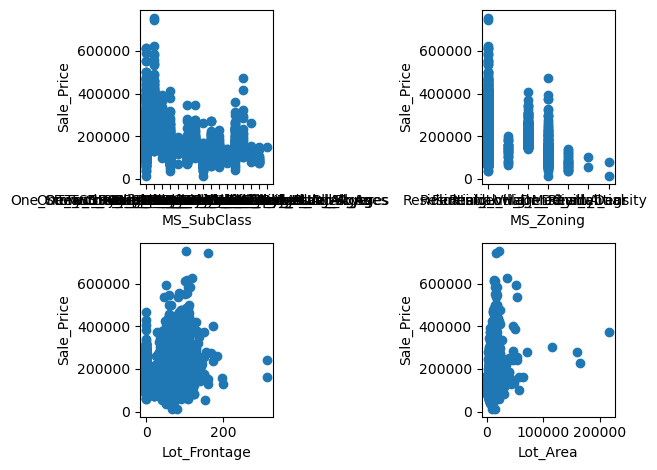

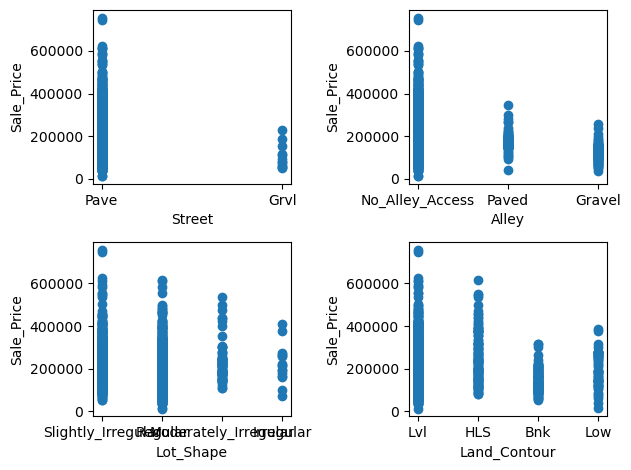

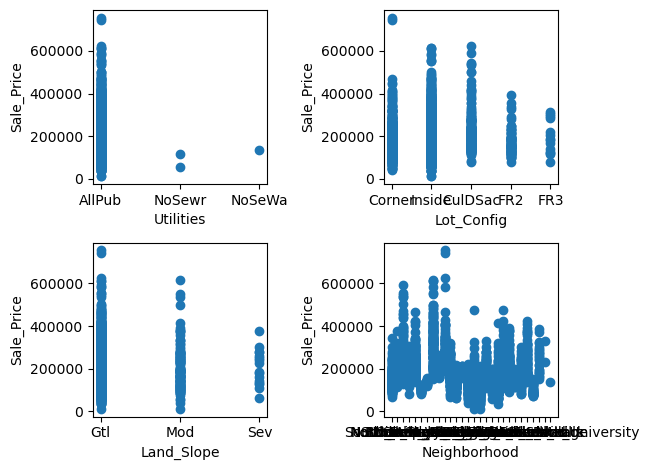

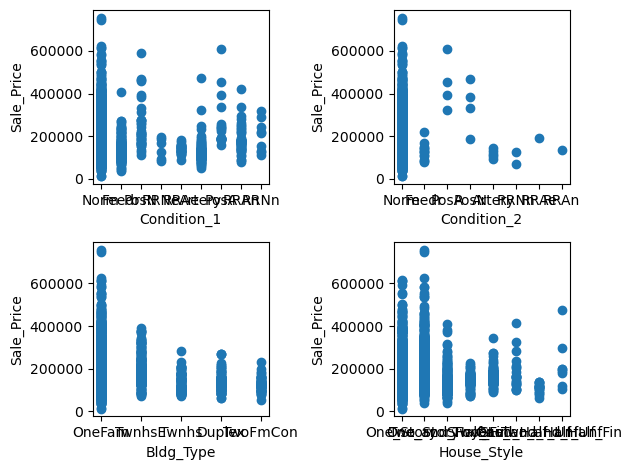

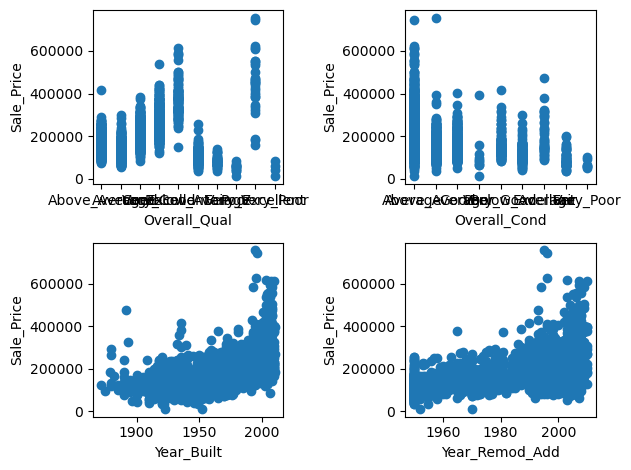

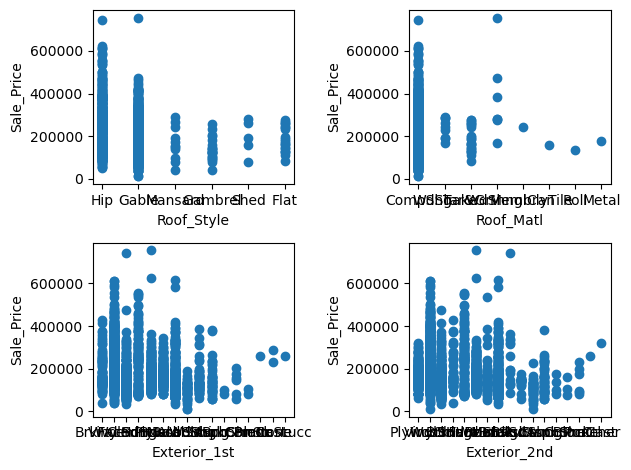

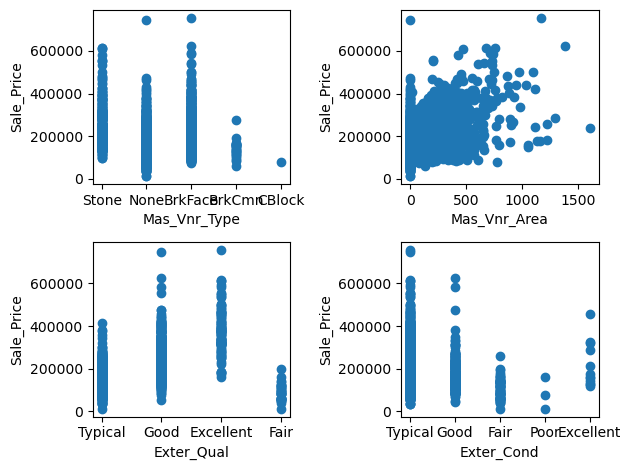

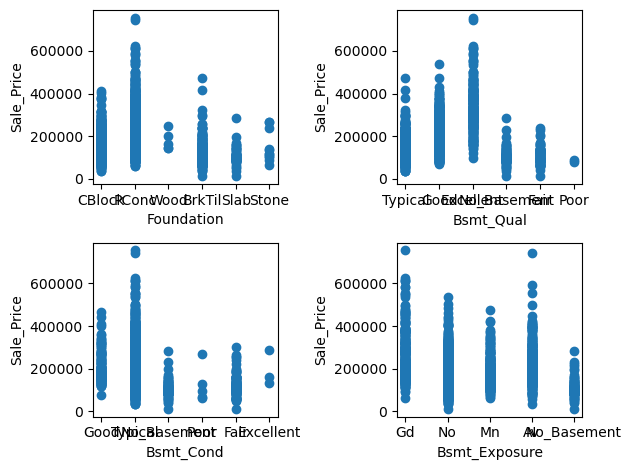

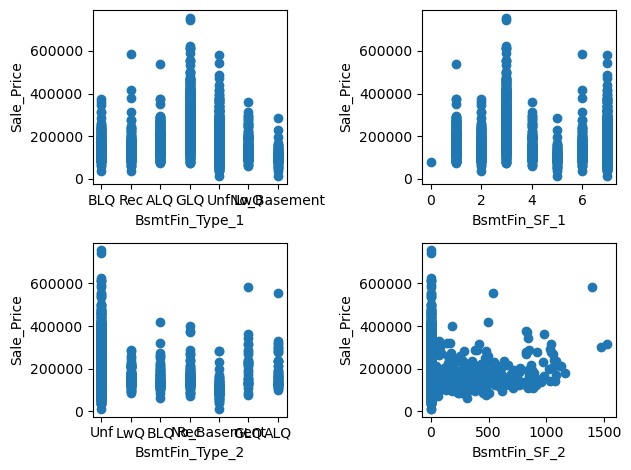

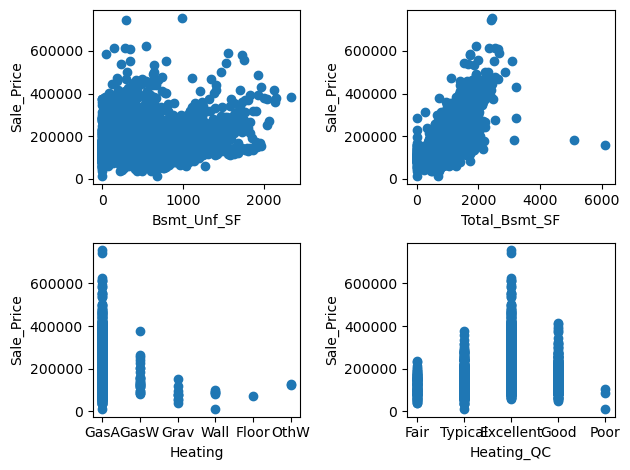

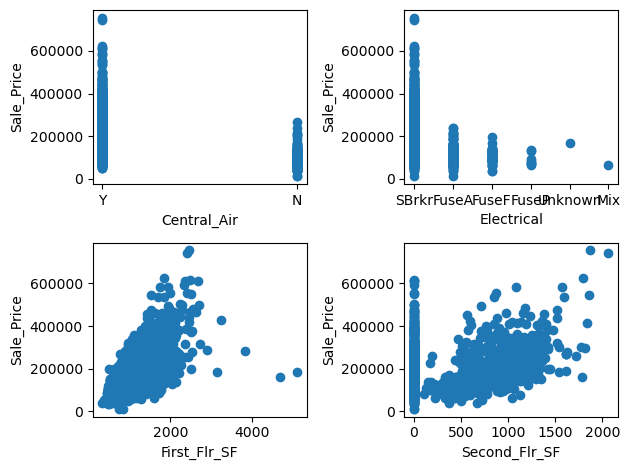

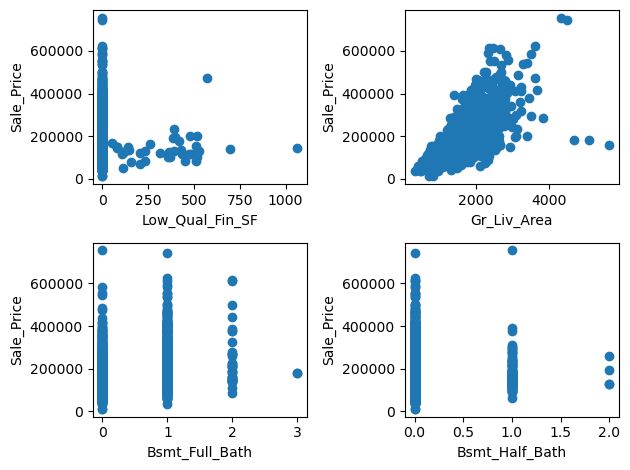

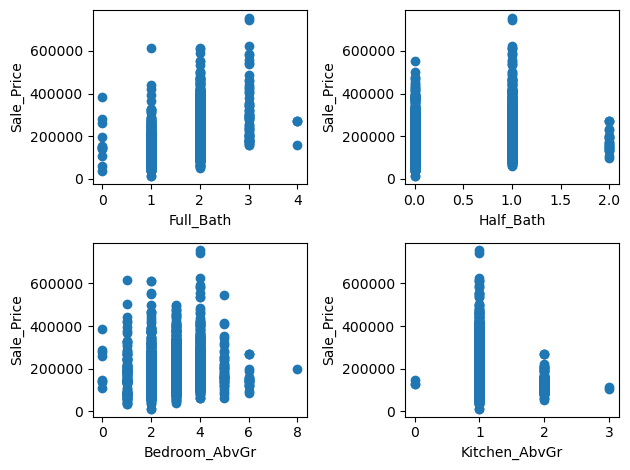

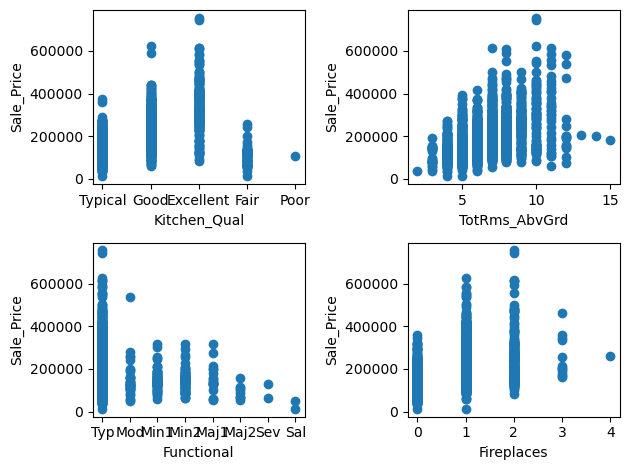

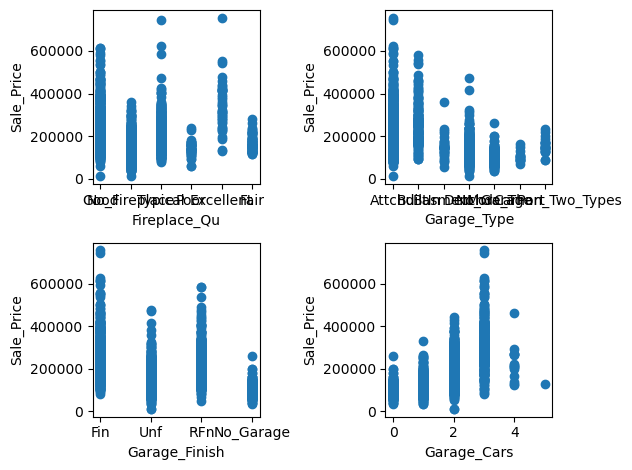

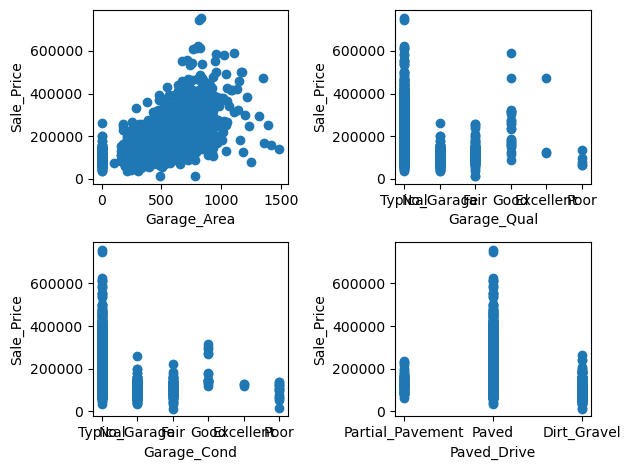

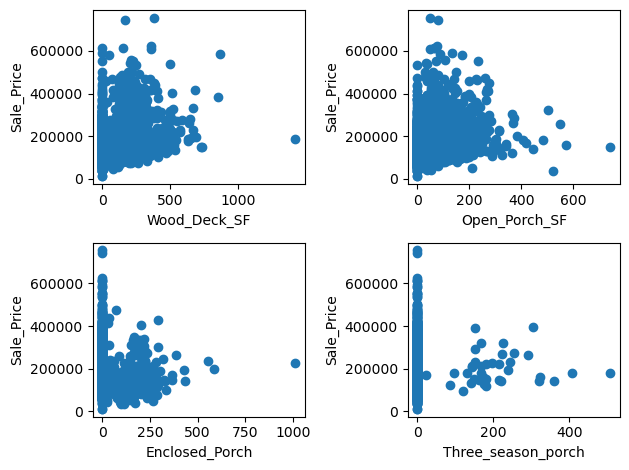

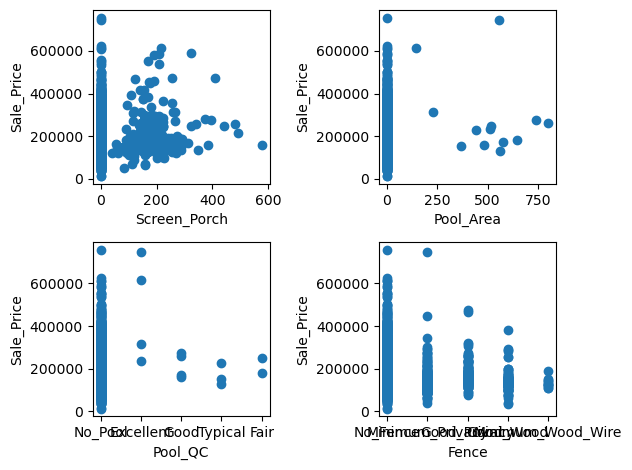

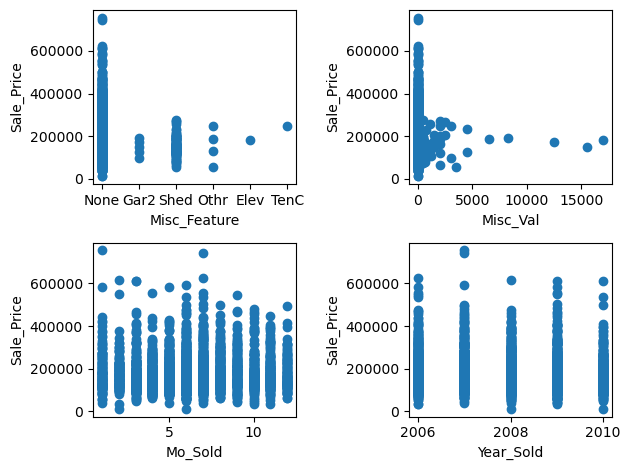

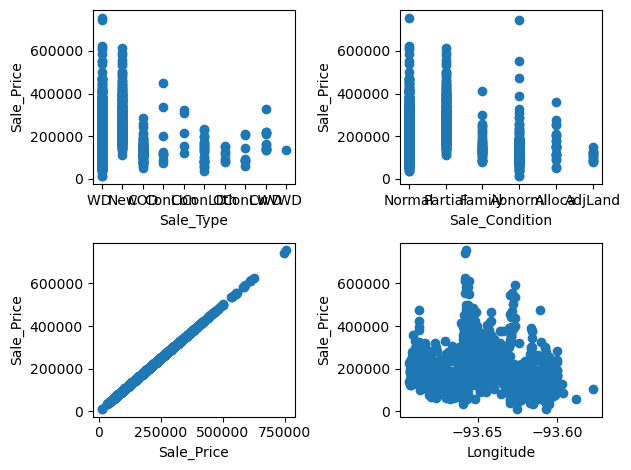

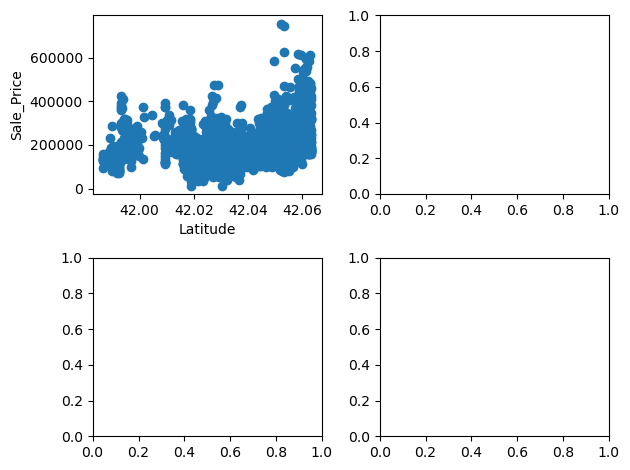

In [5]:
import matplotlib.pyplot as plt

data = pandas.DataFrame(dataset[0])

fig, axs = None, None

for index, i in enumerate(data.columns):
    if index % 4 == 0:
        if fig:
            fig.tight_layout()

        j, k = 0, 0
        fig, axs = plt.subplots(2, 2)
    else:
        if k < 1:
            k += 1
        elif j < 1:
            j += 1
            k -= 1
        else:
            k += 1

    axs[j, k].plot(data[i], data['Sale_Price'], 'o')
    axs[j, k].set_xlabel(i)
    axs[j, k].set_ylabel('Sale_Price')
    
fig.tight_layout()


# Decision trees
> Applicazione dei decision tre al dataset

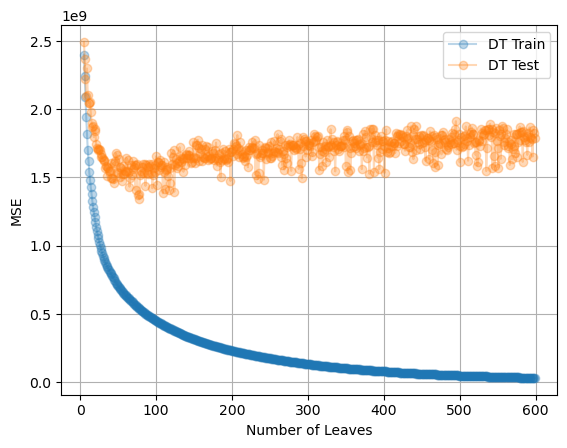

In [6]:
import pandas
from scipy.io import arff
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dataset = arff.loadarff('ames_housing.arff')
data = pandas.DataFrame(dataset[0])

X = data._get_numeric_data()
X = X.loc[:, ~X.columns.isin(
    ['Sale_Price', 'Longitude', 'Latitude', 'TotRms_AbvGrd'])]
X = X.loc[:, ~X.columns.isin(
    [col for col in X if len(X[col].value_counts()) < 13])]

y = data['Sale_Price']

# split dataset in train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

errors = []

for max_leaves in range(5, 600):
    # train and predict
    dt = DecisionTreeRegressor(max_leaf_nodes=max_leaves)
    dt.fit(X_train,y_train)

    # compute Accuracy
    train_acc = mean_squared_error(y_true=y_train, y_pred=dt.predict(X_train))
    test_acc  = mean_squared_error(y_true=y_test,  y_pred=dt.predict(X_test))

    errors += [ [max_leaves, train_acc, test_acc] ]

errors = np.array(errors)

fig, ax = plt.subplots()
ax.plot(errors[:, 0], errors[:, 1], "o-", label="DT Train", alpha=0.3)
ax.plot(errors[:, 0], errors[:, 2], "o-", label="DT Test", alpha=0.3)
ax.set_ylabel("MSE")
ax.set_xlabel("Number of Leaves")
ax.grid()
ax.legend();

# Comparazione con regressione lineare

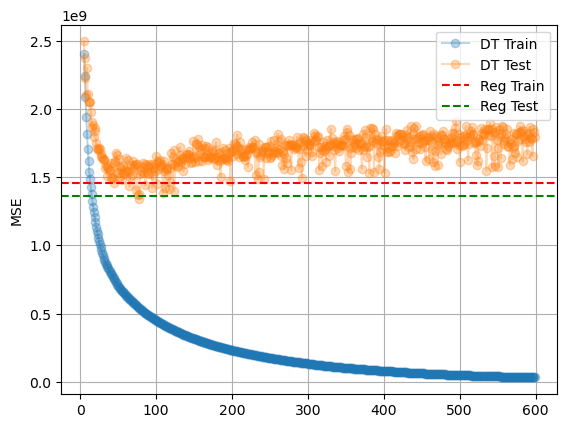

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train,y_train)

reg_train_err = mean_squared_error(y_true=y_train, y_pred=reg.predict(X_train))
reg_test_err  = mean_squared_error(y_true=y_test,  y_pred=reg.predict(X_test))

fig, ax = plt.subplots()
ax.plot(errors[:, 0], errors[:, 1], "o-", label="DT Train", alpha=0.3)
ax.plot(errors[:, 0], errors[:, 2], "o-", label="DT Test", alpha=0.3)

ax.axhline(y=reg_train_err, c='red', ls="--", label="Reg Train")
ax.axhline(y=reg_test_err, c='green', ls="--", label="Reg Test")

ax.set_ylabel("MSE")
ax.grid()
ax.legend();

# Comparazione con KNeighborsRegressor

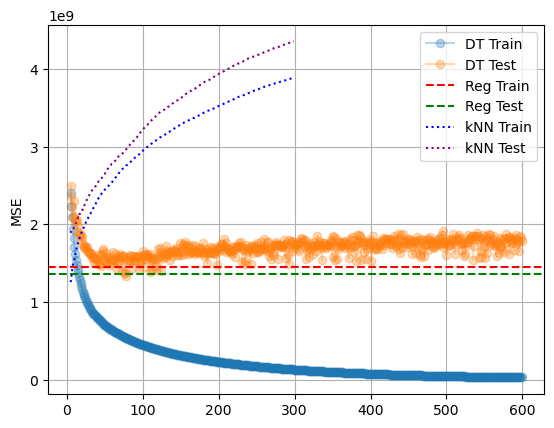

In [8]:
from sklearn.neighbors import KNeighborsRegressor

errors_knn = []
for k in range(5, 300):
    kNN = KNeighborsRegressor(n_neighbors=k)
    kNN.fit(X_train, y_train)

    knn_train_err = mean_squared_error(
        y_true=y_train, y_pred=kNN.predict(X_train))
    knn_test_err = mean_squared_error(
        y_true=y_test,  y_pred=kNN.predict(X_test))

    errors_knn += [ [k, knn_train_err, knn_test_err] ]

errors_knn = np.array(errors_knn)

fig, ax = plt.subplots()
ax.plot(errors[:, 0], errors[:, 1], "o-", label="DT Train", alpha=0.3)
ax.plot(errors[:, 0], errors[:, 2], "o-", label="DT Test", alpha=0.3)

ax.axhline(y=reg_train_err, c='red', ls="--", label="Reg Train")
ax.axhline(y=reg_test_err, c='green', ls="--", label="Reg Test")

ax.plot(errors_knn[:, 0], errors_knn[:, 1], c='blue', ls="dotted", label="kNN Train")
ax.plot(errors_knn[:, 0], errors_knn[:, 2], c='purple', ls="dotted", label="kNN Test")

ax.set_ylabel("MSE")
ax.grid()
ax.legend()